In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
df=pd.read_csv('Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df.shape

(13320, 9)

In [4]:
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

lets consider 'area_type','society','balcony','availability' are not useful for model

In [5]:
df.drop(['area_type','society','balcony','availability'],axis=1,inplace=True)

In [6]:
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


### Data Cleaning: Handle NA values

<AxesSubplot:>

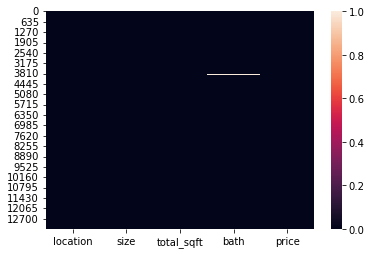

In [7]:
sns.heatmap(df.isnull())

In [8]:
df.isnull().sum()            #this much of row does not contain value

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [9]:
df.dropna(inplace=True)
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

# Feature Engineering

In [10]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [11]:
df['bhk']=df['size'].apply(lambda x: int(x.split()[0]))        

                      or
list(map(lambda x: int(x.split()[0]),df['size']))

In [12]:
df.drop('size',axis=1,inplace=True)

In [13]:
df.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2


In [14]:
df['total_sqft'].dtype

dtype('O')

In [15]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

check is it float or not

In [16]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [17]:
df[~df['total_sqft'].apply(is_float)]                    #non float values

,location,total_sqft,bath,price,bhk
30,Yelahanka,2100 - 2850,4.0,186.000,4
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,43.490,2
188,KR Puram,1015 - 1540,2.0,56.800,2
...,...,...,...,...,...
12975,Whitefield,850 - 1060,2.0,38.190,2
12990,Talaghattapura,1804 - 2273,3.0,122.000,3
13059,Harlur,1200 - 1470,2.0,72.760,2
13265,Hoodi,1133 - 1384,2.0,59.135,2


Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [18]:
def convert_range_to_num(x):
    tokens=x.split('-')
    if len(tokens)==2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [19]:
df1=df.copy()
df1['total_sqft']=df1['total_sqft'].apply(convert_range_to_num)
print(len(df1[df1['total_sqft'].notnull()]))                                 #46 rows consists not a number drop them
df=df1[df1['total_sqft'].notnull()]

13200


In [20]:
df.loc[30]

location      Yelahanka
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [21]:
(2100+2850)/2

2475.0

# Feature Engineering

Add new feature called price per square feet

In [22]:
df2=df.copy()
df2['price_per_square_feet']=np.round(df['price']*100000/df['total_sqft'],2)

In [23]:
df2

,location,total_sqft,bath,price,bhk,price_per_square_feet
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.81
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.38
2,Uttarahalli,1440.0,2.0,62.00,3,4305.56
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.89
4,Kothanur,1200.0,2.0,51.00,2,4250.00
...,...,...,...,...,...,...
13315,Whitefield,3453.0,4.0,231.00,5,6689.83
13316,Richards Town,3600.0,5.0,400.00,4,11111.11
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2,5258.55
13318,Padmanabhanagar,4689.0,4.0,488.00,4,10407.34


#### Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [24]:
df2['location'].nunique()            #multidiamentional problem

1298

In [25]:
df2['location']=df2['location'].apply(lambda x:x.strip())

In [26]:
location_stats=df2['location'].value_counts(ascending=False)
location_stats

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

In [27]:
location_stats.values.sum()

13200

In [28]:
len(location_stats[location_stats>10])

240

In [29]:
len(location_stats[location_stats<=10])

1047

keep these 240 and others having data less than 10 occurances, convert them into others category

### Dimensionality Reduction

Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [30]:
location_stats_lessthan_10=location_stats[location_stats<=10]

In [31]:
df2.location=df2['location'].apply(lambda x: 'others' if x in location_stats_lessthan_10 else x)

In [32]:
df2.location.nunique()

241

In [33]:
df2.head(10)

,location,total_sqft,bath,price,bhk,price_per_square_feet
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.81
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.38
2,Uttarahalli,1440.0,2.0,62.00,3,4305.56
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.89
4,Kothanur,1200.0,2.0,51.00,2,4250.00
5,Whitefield,1170.0,2.0,38.00,2,3247.86
6,Old Airport Road,2732.0,4.0,204.00,4,7467.06
7,Rajaji Nagar,3300.0,4.0,600.00,4,18181.82
8,Marathahalli,1310.0,3.0,63.25,3,4828.24
9,others,1020.0,6.0,370.00,6,36274.51


# OUTLIERS

As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [34]:
df[df2['total_sqft']/df2['bhk']<300]

,location,total_sqft,bath,price,bhk
9,Gandhi Bazar,1020.0,6.0,370.0,6
45,HSR Layout,600.0,9.0,200.0,8
58,Murugeshpalya,1407.0,4.0,150.0,6
68,Devarachikkanahalli,1350.0,7.0,85.0,8
70,Double Road,500.0,3.0,100.0,3
...,...,...,...,...,...
13277,Kundalahalli Colony,1400.0,7.0,218.0,7
13279,Vishwanatha Nagenahalli,1200.0,5.0,130.0,6
13281,Margondanahalli,1375.0,5.0,125.0,5
13303,Vidyaranyapura,774.0,5.0,70.0,5


Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [35]:
df2.shape

(13200, 6)

In [36]:
df3 = df2[~(df2.total_sqft/df2.bhk<300)]
df3.shape                                               #13200-744 doesnot matter

(12456, 6)

In [37]:
df3.head()

,location,total_sqft,bath,price,bhk,price_per_square_feet
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.81
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.38
2,Uttarahalli,1440.0,2.0,62.00,3,4305.56
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.89
4,Kothanur,1200.0,2.0,51.00,2,4250.00


### Outlier Removal Using Standard Deviation and Mean

In [38]:
df3.price_per_square_feet.describe()

count     12456.000000
mean       6308.502836
std        4168.127366
min         267.830000
25%        4210.530000
50%        5294.120000
75%        6916.670000
max      176470.590000
Name: price_per_square_feet, dtype: float64

C:\Users\Rohit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price_per_square_feet'>

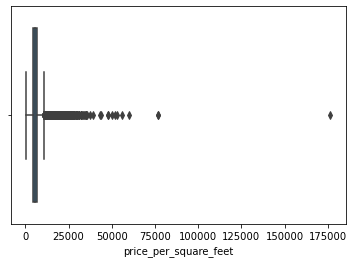

In [39]:
sns.boxplot(df3.price_per_square_feet)

Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [40]:
#############################
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_square_feet)
        st = np.std(subdf.price_per_square_feet)
        reduced_df = subdf[(subdf.price_per_square_feet>(m-st)) & (subdf.price_per_square_feet<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df4 = remove_pps_outliers(df3)
df4.shape

(10242, 6)

### Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

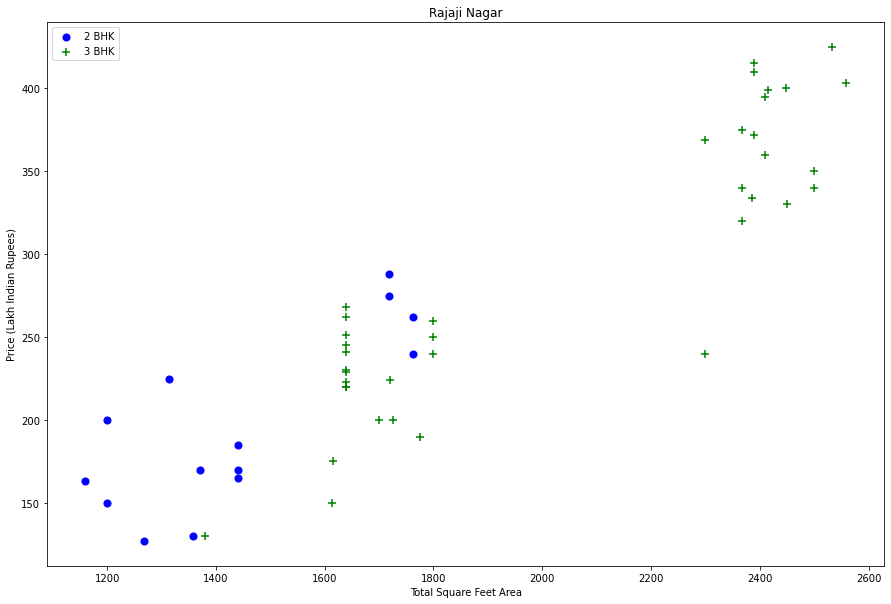

In [41]:
def plot_scatter_chart(df,location):
    
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    plt.figure(figsize=(15,10))
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df4,"Rajaji Nagar")


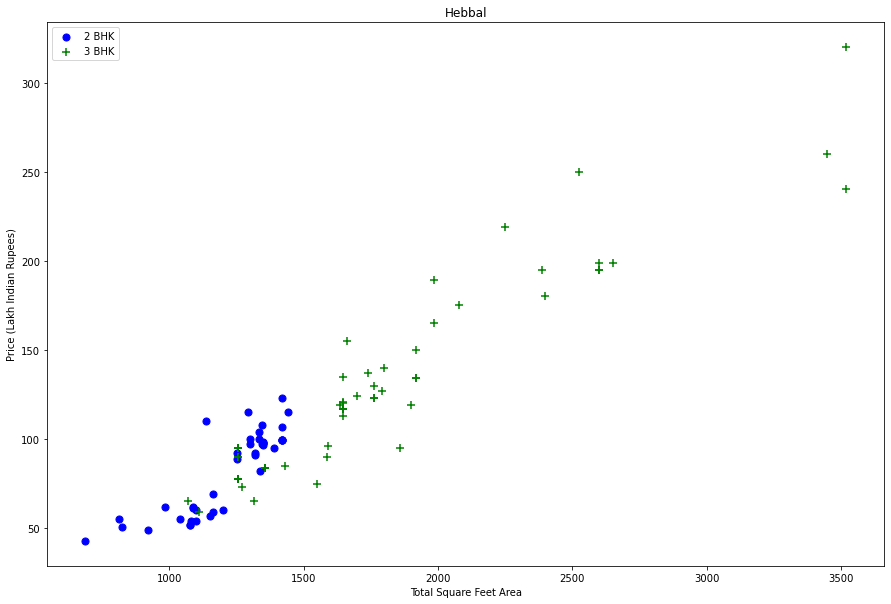

In [42]:
plot_scatter_chart(df4,"Hebbal")

##### We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.

# {
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}


Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [43]:
##################################################################################################


def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_square_feet),
                'std': np.std(bhk_df.price_per_square_feet),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_square_feet<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df4)
# df8 = df7.copy()
df8.shape

(7317, 6)

In [44]:
df8

,location,total_sqft,bath,price,bhk,price_per_square_feet
0,1st Block Jayanagar,2850.0,4.0,428.0,4,15017.54
1,1st Block Jayanagar,1630.0,3.0,194.0,3,11901.84
2,1st Block Jayanagar,1875.0,2.0,235.0,3,12533.33
3,1st Block Jayanagar,1200.0,2.0,130.0,3,10833.33
4,1st Block Jayanagar,1235.0,2.0,148.0,2,11983.81
...,...,...,...,...,...,...
10233,others,1200.0,2.0,70.0,2,5833.33
10234,others,1800.0,1.0,200.0,1,11111.11
10237,others,1353.0,2.0,110.0,2,8130.08
10238,others,812.0,1.0,26.0,1,3201.97


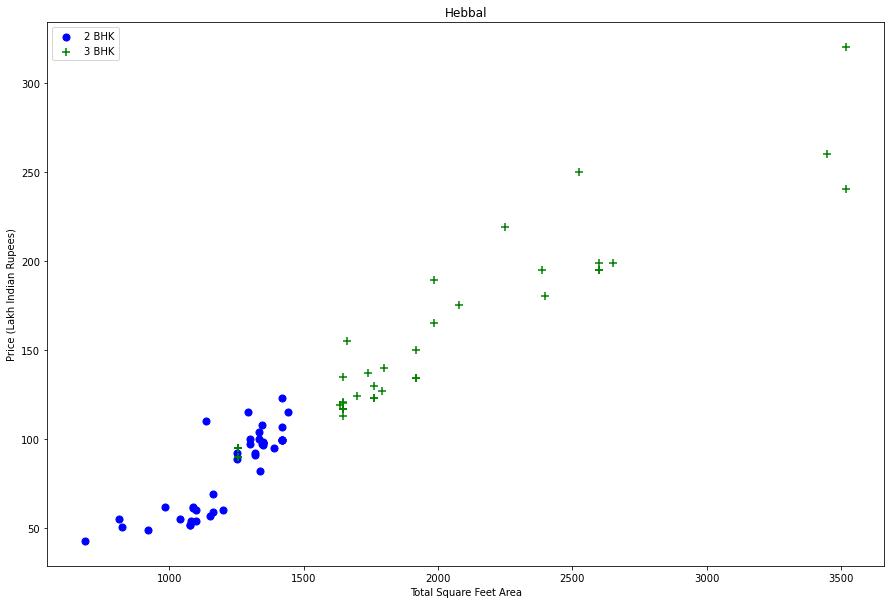

In [45]:
plot_scatter_chart(df8,"Hebbal")

(array([ 548., 3580., 2299.,  457.,  253.,  115.,   39.,   16.,    5.,
           5.]),
 array([ 1300.  ,  3620.98,  5941.96,  8262.94, 10583.92, 12904.9 ,
        15225.88, 17546.86, 19867.84, 22188.82, 24509.8 ]),
 <BarContainer object of 10 artists>)

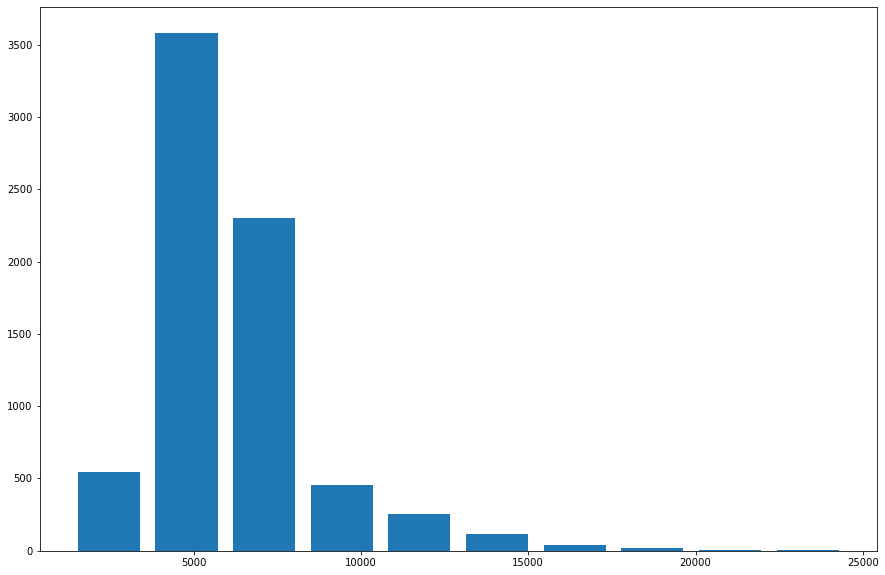

In [46]:
plt.figure(figsize=(15,10))
plt.hist(df8.price_per_square_feet,rwidth=0.8)

# Outlier Removal Using Bathrooms Feature

In [47]:
df8.bath.nunique()

12

Text(0, 0.5, 'Count')

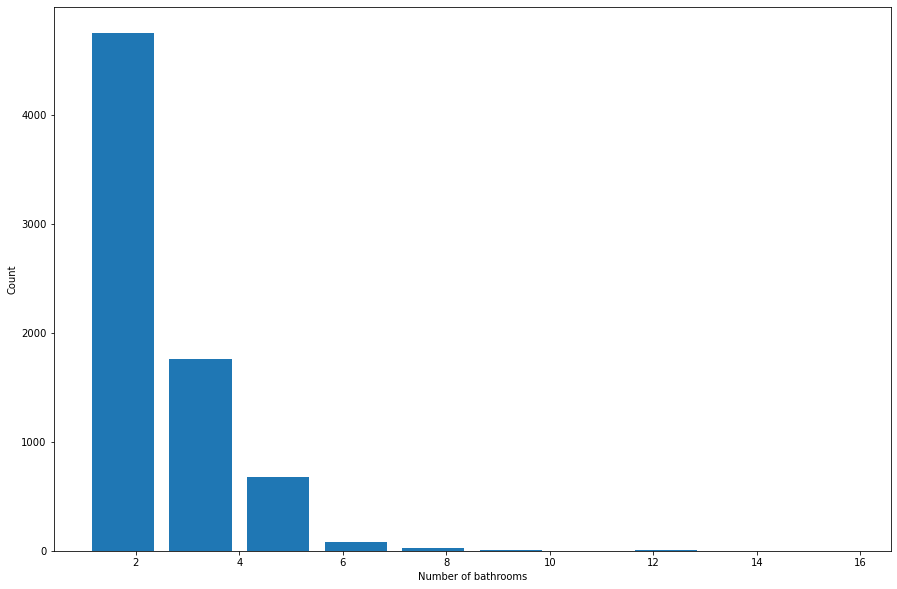

In [48]:
plt.figure(figsize=(15,10))
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [49]:
df8[df8.bath>10]

,location,total_sqft,bath,price,bhk,price_per_square_feet
5277,Neeladri Nagar,4000.0,12.0,160.0,10,4000.00
8483,others,12000.0,12.0,525.0,10,4375.00
8572,others,10000.0,16.0,550.0,16,5500.00
9306,others,6000.0,12.0,150.0,11,2500.00
9637,others,5425.0,13.0,275.0,13,5069.12


### It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [50]:
df8[df8.bath>(df8.bhk+2)]

,location,total_sqft,bath,price,bhk,price_per_square_feet
1626,Chikkabanavar,2460.0,7.0,80.0,4,3252.03
5238,Nagasandra,7000.0,8.0,450.0,4,6428.57
6711,Thanisandra,1806.0,6.0,116.0,3,6423.03
8408,others,11338.0,9.0,1000.0,6,8819.90


Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed

In [51]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7239, 6)

In [52]:
df9.drop('price_per_square_feet',axis=1,inplace=True)

C:\Users\Rohit\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [53]:
df9

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2
...,...,...,...,...,...
10233,others,1200.0,2.0,70.0,2
10234,others,1800.0,1.0,200.0,1
10237,others,1353.0,2.0,110.0,2
10238,others,812.0,1.0,26.0,1


# Use One Hot Encoding For Location

In [54]:
dummies=pd.get_dummies(df9.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,others
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
df11 = pd.concat([df9,dummies],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,others
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
df11.drop(['location','others'],axis=1,inplace=True)

# Build a Model Now...

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df11.drop('price',axis=1),df11.price, test_size=0.2, random_state=10)

In [58]:
from sklearn.linear_model import LinearRegression

In [59]:
model=LinearRegression()

In [60]:
model.fit(X_train,y_train)

LinearRegression()

In [61]:
model.score(X_train,y_train)

0.8523137584485154

In [62]:
y_pred=model.predict(X_test)
y_pred

array([123.68919775,  79.12643295,  76.7573612 , ...,  58.55465139,
        99.4418541 , 135.74127115])

In [63]:
from sklearn.metrics import classification_report,confusion_matrix

In [64]:
#######classification_report(y_test,y_pred)                check why not working

# Use K Fold cross validation to measure accuracy of our LinearRegression model

In [65]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [66]:
cv=ShuffleSplit(n_splits=5, test_size=.2, random_state=0)                             #Random permutation cross-validator

In [67]:
cross_val_score(LinearRegression(),df11.drop('price',axis=1),df11.price,cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

#### We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose

# Find best model using GridSearchCV

In [68]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

In [69]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(df11.drop('price',axis=1),df11.price)

C:\Users\Rohit\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\Rohit\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model =

,model,best_score,best_params
0,linear_regression,0.847796,{'normalize': False}
1,lasso,0.726738,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.724062,"{'criterion': 'mse', 'splitter': 'random'}"


# linear_regression is best

# Test the model for few properties

In [70]:
X=df11.drop('price',axis=1)
y=df11.price

In [71]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return model.predict([x])[0]

In [72]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

C:\Users\Rohit\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


83.86570258324036

In [73]:

predict_price('1st Phase JP Nagar',1000, 3, 3)

C:\Users\Rohit\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


86.08062284998763